<a href="https://colab.research.google.com/github/SaMMYFrosT221b/Malignency_Detection_Using_Deep_Learning/blob/shishu/idp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [29]:
! pip install opendatasets

In [30]:
! pip install pandas

In [31]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import os

%matplotlib inline

In [33]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

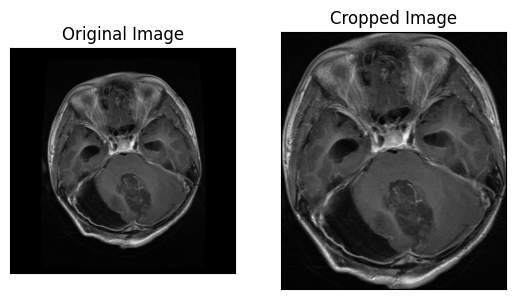

In [34]:
ex_img = cv2.imread('/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [37]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time

In [38]:
def augmented_data(image_directory, n_generated_samples, save_to_dir):
    # save_to_dir = "/content/augmented/yes"
    # image_directory = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/'
    image_files = os.listdir(image_directory)
    data_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              brightness_range=(0.3, 1.0),
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest'
                             )

    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        image = cv2.imread(image_path)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + image_file[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [39]:
# augment data for the examples with label equal to 'yes' representing tumurous examples
augmented_data(image_directory='/content/brain-tumor-mri-dataset/Testing/glioma', n_generated_samples=6, save_to_dir='/content/augmented/yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augmented_data(image_directory='/content/brain-tumor-mri-dataset/Testing/notumor', n_generated_samples=9, save_to_dir='/content/augmented/no')